# Import and Class Section

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import os
import cv2
import sys
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import torch.backends.cudnn as cudnn

np.set_printoptions(threshold=np.inf)
sys.path.append("../libs")

from nms import nms
from tqdm import tqdm
from track.KCF import Tracker
from collections import deque
from torch.autograd import Variable
from networks.Pelee.configs.CC import Config
from networks.Pelee.data import BaseTransform
# from scipy.optimize import linear_sum_assignment
from networks.Pelee.utils.core import anchors, init_net
from networks.Pelee.layers.functions import Detect, PriorBox

# from networks.Pelee.peleenet import build_net as build_net
from networks.Pelee.peleenet_reduced import build_net as build_net

In [28]:
def plot(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()
    
class Average(object):
    def __init__(self):
        self.values = []
    
    def get(self):
        return sum(self.values) / len(self.values)
    
    def add(self, value):
        self.values.append(value)
        
class Timer(object):
    def __init__(self):
        self.time = 0
        self.start_time = 0
        self.end_time = 0
        
    def start(self):
        self.start_time = time.time()
    
    def stop(self):
        self.end_time = time.time()
    
    def get(self):
        return self.end_time - self.start_time

In [5]:
class PeleeNet(object):
    def __init__(self, cfg_path, weight_path, thr):
        cfg = Config.fromfile(cfg_path)
        anchor_config = anchors(cfg.model)
        priorbox = PriorBox(anchor_config)
        self.net = build_net('test', cfg.model.input_size, cfg.model)
    
        # if 'reduced' in cfg_path:
        #     self.net = build_net_reduced('test', cfg.model.input_size, cfg.model)
        # else:
        #     self.net = build_net('test', cfg.model.input_size, cfg.model)
        init_net(self.net, cfg, weight_path)
        self.net.eval()
        self.num_classes = cfg.model.num_classes
        self.thresh = thr
        self.nms_threshold = 0.45
        self.softmax = torch.nn.Softmax(dim=-1)
        self.img = None
        self.save_root = weight_path
        self.cfg = cfg
        
        with torch.no_grad():
            self.priors = priorbox.forward()
            if cfg.test_cfg.cuda:
                self.net = self.net.cuda()
                self.priors = self.priors.cuda()
                cudnn.benchmark = True
            else:
                self.net = self.net.cpu()

        self.detector = Detect(self.num_classes, cfg.loss.bkg_label, anchor_config)
        self.t = BaseTransform(cfg.model.input_size, cfg.model.rgb_means)
        
    def predict(self, image, center=False):
        with torch.no_grad():
            self.img = Variable(self.t(image).unsqueeze(0)).cuda()
            w, h = image.shape[1], image.shape[0]

            out_ = self.net(self.img)
            np.savetxt("conf_torch.txt", out_[1].cpu().numpy())
            np.savetxt("loc_torch.txt", out_[0].cpu().numpy())
            
            loc = out_[0].view(1, -1, 4)
            conf = self.softmax(out_[1].view(-1, self.num_classes))
            
            out = (loc, conf)
            scale = torch.Tensor([w, h, w, h]).cuda()
            boxes, scores = self.detector.forward(out, self.priors)
            boxes = (boxes[0] * scale).cpu().numpy()
            scores = scores[0].cpu().numpy()
            all_boxes = [np.array([]) for _ in range(self.num_classes)]
            
            for j in range(1, self.num_classes):
                inds = np.where(scores[:, j] > self.thresh)[0]
                if len(inds) == 0:
                    all_boxes[j] = np.empty([0, 5], dtype=np.float32)
                    continue
                c_bboxes = boxes[inds]
                c_scores = scores[inds, j]
                c_dets = np.hstack((c_bboxes, c_scores[:, np.newaxis])).astype(np.float32, copy=False)
                keep = nms(c_dets, self.nms_threshold)
                keep = keep[:50]
                c_dets = c_dets[keep, :]
                all_boxes[j] = c_dets.astype(np.float32)
                
            if center:
                return self.to_center(all_boxes[1])
            else:
                return all_boxes[1]
            
    def to_center(self, bboxes):
        centers = []
        whs = []
        for bbox in bboxes:
            cx, cy = int((bbox[0] + bbox[2])/2), int((bbox[1] + bbox[3])/2)
            hw, hh = int((bbox[2] - bbox[0])/2), int((bbox[3] - bbox[1])/2)
            whs.append([hw, hh])
            centers.append([cx, cy])
        return np.array(centers), np.array(whs)
    
    def convert_onnx(self, model_path):
        dummy_input = torch.randn(1, 1, self.cfg.model.input_size, self.cfg.model.input_size).cuda()
        
        torch.onnx.export(self.net,
                            dummy_input,
                            model_path,
                            export_params=True,  # store the trained parameter weights inside the model file 
                            opset_version=8,    # the ONNX version to export the model to 
                            input_names = ['inputs'],   # the model's input names 
                            output_names = ['loc', 'conf'], # the model's output names 
                         ) 
    

# Setup Section

In [6]:
# video_name = "../archives/videos/B3S27.mp4"
ROOT = "../archives/weights/PeleeNet"
cfg_name = "color_gauge.py"
folder = "ptm_gauge"
weight_path = "/mnt/3694a998-c714-43da-99b1-66f85757d25d/gauge"
name = "color_gauge2/Pelee_color_gauge2_size304_epoch40.pth"
thr = 0.5

interpolate_frames = 9
# timer = Timer()

In [7]:
pure_ml_outputs = []
ml_interp_outputs = []

# Configs

In [8]:
cfg_path = os.path.join(ROOT, "configs", cfg_name)
weight_path = os.path.join(weight_path, name)
model_path = os.path.join(ROOT, folder, "gauge.onnx")
pelee = PeleeNet(cfg_path, weight_path, thr)

Loading resume network...


# Export to ONNX

In [ ]:
pelee.convert_onnx(model_path)
# pelee.net.eval()
# tf_rep.export_graph(os.path.join(ROOT, folder, "greyscl_gauge.pb"))

# Detection + Interpolate Tracking

3


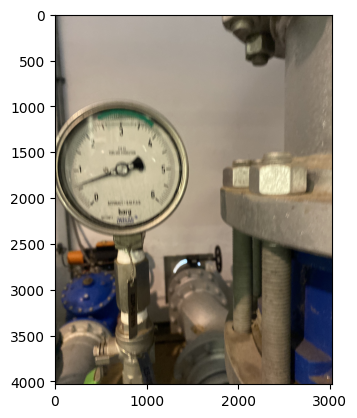

True

In [16]:
id_img =  "303"
fld = "3"

image_path = f"/mnt/3694a998-c714-43da-99b1-66f85757d25d/gauge/Dataset/{fld}/JPEGImages"
xml_path = f"/mnt/3694a998-c714-43da-99b1-66f85757d25d/gauge/Dataset/{fld}/Annotations"
image_path = os.path.join(image_path, f"{fld}_{id_img}.jpg")

folder_ = image_path.split("/")[-3]
print(folder_)
if folder_ in ["1", "2", "3"]:
    frame = cv2.imread(image_path, 1)
else:            
    frame = cv2.imread(image_path, 1|cv2.IMREAD_IGNORE_ORIENTATION)
bboxes = pelee.predict(frame)

for box in bboxes:
    startX = int(box[0])
    startY = int(box[1])
    endX = int(box[2])
    endY = int(box[3])
    cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 15)

plot(frame)
cv2.imwrite("sample1.png", frame)

In [33]:
import random
from networks.Pelee.data.data_augment_gauge_color import _rotate, _crop
import numpy as np


# img_list = random.sample(range(0,1200),30)

# for id_img in img_list:
# id_img =  "635"
# fld = "2"

# image_path = f"/mnt/3694a998-c714-43da-99b1-66f85757d25d/gauge/Dataset/{fld}/JPEGImages"
# grey = cv2.imread(os.path.join(image_path, f"{fld}_{id_img}.jpg"), 1|cv2.IMREAD_IGNORE_ORIENTATION)

# frame = cv2.imread(os.path.join(image_path, f"{fld}_{id_img}.jpg"), 1|cv2.IMREAD_IGNORE_ORIENTATION)
# frame = cv2.imread(os.path.join(image_path, f"{fld}_{id_img}.jpg"), 1)

# target = tree.getroot()
# print(grey.shape)
# bboxes = pelee.predict(grey)
fp = ['3_480', '3_298', 'PI4-9_78', '3_249', '3_537', 'PI4-9_10', 'PI4-9_382', 'PI4-9_199', 'PI10-9_241', 'PI4-9_18', 'PI6-19_54', '1_556', '1_75', '1_300', 
      'PI4-9_372', '1_562', 'PI4-9_127', 'PI6-19_66', '1_646', 'PI4-9_21', 'PI4-9_182', '1_27', 'PI4-9_281', 'PI4-9_505', 'PI4-9_204', 'PI4-19_92', 'PI10-9_416', 
      'PI4-9_426', 'PI10-9_495', 'PI6-9_299', 'PI4-9_207']
with open("gauge.txt", "r") as file:
    for lines in file.readlines():
        txt = lines.strip()
        [name, conf, x1, y1, x2, y2] = txt.split(" ")
        fld = name.split("_")[0]
        image_path = f"/mnt/3694a998-c714-43da-99b1-66f85757d25d/gauge/Dataset/{fld}/JPEGImages/{name}.jpg"
        if name.split("_")[0] in ["1", "2", "3"]:
            frame = cv2.imread(image_path)
        else:    
            frame = cv2.imread(image_path, cv2.IMREAD_COLOR|cv2.IMREAD_IGNORE_ORIENTATION)
        image = cv2.rectangle(frame, (int(float(x1)), int(float(y1))), (int(float(x2)), int(float(y2))), (0,255,0), 10)
        if name in fp:
            cv2.imwrite(f"fp/{name}.png", image)
        else:
            cv2.imwrite(f"result/{name}.png", image)
#         print(f"result/{name}.png")
#         plot(image)
# for obj in target.iter("object"):
#    x = float(obj.find('bndbox/xmin').text)
#    y = float(obj.find('bndbox/ymin').text)
#    x2 = float(obj.find('bndbox/xmax').text)
#    y2 = float(obj.find('bndbox/ymax').text)
#    bboxes.append([x, y, x2, y2])

# image, box, label = _crop(grey, np.array(bboxes), np.array([1]))
# image, box, label = _rotate(image, box, label)


# image, box, label = _rotate(grey, np.array(bboxes), label)
# print(type(box), box)

# for i in bboxes:
#     image = cv2.rectangle(frame, (int(i[0]), int(i[1])), (int(i[2]), int(i[3])), (0,255,0), 10)
# plot(image)
# print(image.shape)